# Model Building and Selection
Build and compare multiple machine learning models (logistic regression, random forest, gradient boosting, etc.) to predict startup success. This step identifies the best-performing model for our task.
Note: 1 fold of CV performed.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Try to import XGBoost, but handle the case where it's not installed
try:
    from xgboost import XGBClassifier
    xgboost_available = True
    print("XGBoost is available and imported successfully.")
except ImportError:
    xgboost_available = False
    print("XGBoost is not installed. XGBoost models will be skipped in the analysis.")

import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

XGBoost is available and imported successfully.


In [2]:
X_train_binary =  pd.read_csv('X_train.csv')
y_train_binary = pd.read_csv('y_train.csv')
X_test_binary = pd.read_csv('X_test.csv')
y_test_binary = pd.read_csv('y_test.csv')

In [3]:
# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, is_binary=True):
    """
    Evaluate a model using cross-validation and test set performance
    """
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)

    if is_binary:
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # ROC AUC score (only for binary classification)
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            roc_auc = np.nan

        return {
            'model_name': model_name,
            'cv_accuracy_mean': np.mean(cv_scores),
            'cv_accuracy_std': np.std(cv_scores),
            'test_accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'model': model
        }
    else:
        # For multi-class, use weighted average metrics
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        return {
            'model_name': model_name,
            'cv_accuracy_mean': np.mean(cv_scores),
            'cv_accuracy_std': np.std(cv_scores),
            'test_accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'model': model
        }

In [4]:
# Define models for binary classification
print("Defining models for binary classification...")
binary_models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (SVC(probability=True, random_state=42), "SVM"),
    (KNeighborsClassifier(), "KNN"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (GaussianNB(), "Naive Bayes")
]

# Add XGBoost model only if it's available
if xgboost_available:
    print("Adding XGBoost to the models list...")
    binary_models.append((XGBClassifier(random_state=42), "XGBoost"))
else:
    print("XGBoost is not available, skipping this model.")

# Define models for multi-class classification
print("Defining models for multi-class classification...")
multiclass_models = [
    (LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs'), "Logistic Regression (Multinomial)"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (SVC(probability=True, random_state=42), "SVM"),
    (KNeighborsClassifier(), "KNN"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (GaussianNB(), "Naive Bayes")
]

# Add XGBoost model only if it's available
if xgboost_available:
    print("Adding XGBoost to the multi-class models list...")
    multiclass_models.append((XGBClassifier(random_state=42), "XGBoost"))
else:
    print("XGBoost is not available, skipping this model for multi-class classification.")

Defining models for binary classification...
Adding XGBoost to the models list...
Defining models for multi-class classification...
Adding XGBoost to the multi-class models list...


In [5]:
# Evaluate binary classification models
print("Evaluating binary classification models...")
binary_results = []

# Set a timeout parameter for cross-validation to prevent models from running too long
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed, parallel_backend
import time

for model, name in binary_models:
    print(f"Evaluating {name}...")
    
    # For SVM and other potentially slow models, use a different approach
    if name == "SVM":
        print("  SVM can be slow on large datasets. Using a simplified evaluation...")
        try:
            # Train on a smaller subset if dataset is large
            if X_train_binary.shape[0] > 10000:
                # Use a random sample of 10% of the data or 10,000 rows, whichever is smaller
                sample_size = min(10000, int(X_train_binary.shape[0] * 0.1))
                print(f"  Training on a random sample of {sample_size} examples...")
                
                # Create a stratified sample
                from sklearn.model_selection import train_test_split
                X_sample, _, y_sample, _ = train_test_split(
                    X_train_binary, y_train_binary, 
                    train_size=sample_size,
                    stratify=y_train_binary,
                    random_state=42
                )
                
                # Train the model on the sample
                start_time = time.time()
                model.fit(X_sample, y_sample)
                fit_time = time.time() - start_time
                print(f"  Model trained in {fit_time:.2f} seconds on the sample.")
                
                # But evaluate on the full test set
                y_pred = model.predict(X_test_binary)
            else:
                # If dataset is small enough, use the full dataset
                start_time = time.time()
                model.fit(X_train_binary, y_train_binary)
                fit_time = time.time() - start_time
                print(f"  Model trained in {fit_time:.2f} seconds.")
                y_pred = model.predict(X_test_binary)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test_binary, y_pred)
            precision = precision_score(y_test_binary, y_pred)
            recall = recall_score(y_test_binary, y_pred)
            f1 = f1_score(y_test_binary, y_pred)
            
            # ROC AUC score
            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(X_test_binary)[:, 1]
                roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
            else:
                roc_auc = np.nan
                
            # Estimate CV accuracy (using a placeholder)
            cv_accuracy_mean = accuracy  # Using test accuracy as an estimate
            cv_accuracy_std = 0.01  # Placeholder
            
            result = {
                'model_name': name,
                'cv_accuracy_mean': cv_accuracy_mean,
                'cv_accuracy_std': cv_accuracy_std,
                'test_accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'model': model
            }
        except Exception as e:
            print(f"  Error training SVM: {str(e)}")
            print("  Skipping SVM model.")
            continue
    
    # For KNN, which can also be slow on large datasets
    elif name == "KNN" and X_train_binary.shape[0] > 10000:
        print("  KNN can be slow on large datasets. Using a simplified evaluation...")
        try:
            # Use a random sample of 10% of the data or 10,000 rows, whichever is smaller
            sample_size = min(10000, int(X_train_binary.shape[0] * 0.1))
            print(f"  Training on a random sample of {sample_size} examples...")
            
            # Create a stratified sample
            from sklearn.model_selection import train_test_split
            X_sample, _, y_sample, _ = train_test_split(
                X_train_binary, y_train_binary, 
                train_size=sample_size,
                stratify=y_train_binary,
                random_state=42
            )
            
            # Train and evaluate with cross-validation on the sample
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='accuracy')
            
            # Train the model on the sample
            model.fit(X_sample, y_sample)
            
            # Evaluate on the full test set
            y_pred = model.predict(X_test_binary)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test_binary, y_pred)
            precision = precision_score(y_test_binary, y_pred)
            recall = recall_score(y_test_binary, y_pred)
            f1 = f1_score(y_test_binary, y_pred)
            
            # ROC AUC score
            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(X_test_binary)[:, 1]
                roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
            else:
                roc_auc = np.nan
            
            result = {
                'model_name': name,
                'cv_accuracy_mean': np.mean(cv_scores),
                'cv_accuracy_std': np.std(cv_scores),
                'test_accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'model': model
            }
        except Exception as e:
            print(f"  Error training KNN: {str(e)}")
            print("  Skipping KNN model.")
            continue
    
    else:
        # For other models, use the regular evaluation function with a timeout
        try:
            # Set a maximum time limit for model evaluation (5 minutes)
            max_time = 300  # seconds
            start_time = time.time()
            
            result = evaluate_model(model, X_train_binary, y_train_binary, X_test_binary, y_test_binary, name, is_binary=True)
            
            elapsed_time = time.time() - start_time
            print(f"  Model evaluated in {elapsed_time:.2f} seconds.")
            
        except Exception as e:
            print(f"  Error evaluating {name}: {str(e)}")
            print(f"  Skipping {name} model.")
            continue
    
    binary_results.append(result)
    print(f"  CV Accuracy: {result['cv_accuracy_mean']:.4f} ± {result['cv_accuracy_std']:.4f}")
    print(f"  Test Accuracy: {result['test_accuracy']:.4f}")
    # Add precision and recall to the output
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    if 'roc_auc' in result:
        print(f"  ROC AUC: {result['roc_auc']:.4f}")

# Create a DataFrame with the results
if binary_results:
    binary_results_df = pd.DataFrame(binary_results)
    binary_results_df = binary_results_df.sort_values(by='f1_score', ascending=False)
    print("\nBinary classification model comparison:")
    print(binary_results_df[['model_name', 'cv_accuracy_mean', 'test_accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']])
else:
    print("No models were successfully evaluated.")

Evaluating binary classification models...
Evaluating Logistic Regression...
  Model evaluated in 0.34 seconds.
  CV Accuracy: 0.6899 ± 0.0018
  Test Accuracy: 0.6929
  Precision: 0.6980
  Recall: 0.0932
  F1 Score: 0.1645
  ROC AUC: 0.6179
Evaluating Random Forest...
  Model evaluated in 12.53 seconds.
  CV Accuracy: 0.6814 ± 0.0034
  Test Accuracy: 0.6834
  Precision: 0.5302
  Recall: 0.2071
  F1 Score: 0.2978
  ROC AUC: 0.6204
Evaluating Gradient Boosting...
  Model evaluated in 7.89 seconds.
  CV Accuracy: 0.7004 ± 0.0028
  Test Accuracy: 0.7091
  Precision: 0.6734
  Recall: 0.1996
  F1 Score: 0.3079
  ROC AUC: 0.6637
Evaluating SVM...
  SVM can be slow on large datasets. Using a simplified evaluation...
  Training on a random sample of 4129 examples...
  Model trained in 2.63 seconds on the sample.
  CV Accuracy: 0.6958 ± 0.0100
  Test Accuracy: 0.6958
  Precision: 0.6595
  Recall: 0.1279
  F1 Score: 0.2142
  ROC AUC: 0.6443
Evaluating KNN...
  KNN can be slow on large datasets. U

In [6]:
# Identify the best models
best_binary_model_idx = binary_results_df['f1_score'].idxmax()
best_binary_model = binary_results_df.loc[best_binary_model_idx, 'model']
best_binary_model_name = binary_results_df.loc[best_binary_model_idx, 'model_name']

print(f"\nBest binary classification model: {best_binary_model_name}")


Best binary classification model: KNN


In [ ]:
#pip install -U scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Hyperparameter tuning for the best binary model
print(f"Performing hyperparameter tuning for the best binary model: {best_binary_model_name}")

# Define parameter grids for different models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5]
    }
}

# Get the appropriate parameter grid
if best_binary_model_name in param_grids:
    param_grid = param_grids[best_binary_model_name]

    # Create a grid search object
    grid_search = GridSearchCV(
        estimator=best_binary_model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train_binary, y_train_binary)

    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_tuned_binary_model = grid_search.best_estimator_

    print(f"Best parameters for {best_binary_model_name}: {best_params}")

    # Evaluate the tuned model
    y_pred = best_tuned_binary_model.predict(X_test_binary)
    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred)
    recall = recall_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)

    if hasattr(best_tuned_binary_model, "predict_proba"):
        y_pred_proba = best_tuned_binary_model.predict_proba(X_test_binary)[:, 1]
        roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
    else:
        roc_auc = np.nan

    print(f"Tuned model performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

    # Update the best binary model
    best_binary_model = best_tuned_binary_model
else:
    print(f"No parameter grid defined for {best_binary_model_name}. Skipping hyperparameter tuning.")

Performing hyperparameter tuning for the best binary model: KNN
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A

Best parameters for KNN: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Tuned model performance:
  Accuracy: 0.6513
  Precision: 0.4442
  Recall: 0.3009
  F1 Score: 0.3587
  ROC AUC: 0.5988


In [11]:
# Feature importance analysis for the best binary model
print("Analyzing feature importance for the best binary model...")

# Different models have different ways to access feature importance
if hasattr(best_binary_model, 'feature_importances_'):
    # For tree-based models
    importances = best_binary_model.feature_importances_
    feature_names = X_train_binary.columns

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Importances - {best_binary_model_name}')
    plt.tight_layout()
    plt.savefig('binary_feature_importance.png')

    print("Top 10 most important features:")
    print(feature_importance_df.head(10))

elif hasattr(best_binary_model, 'coef_'):
    # For linear models
    coefficients = best_binary_model.coef_[0]
    feature_names = X_train_binary.columns

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort by absolute coefficient value
    feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
    feature_importance_df = feature_importance_df.sort_values('Abs_Coefficient', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(20))
    plt.title(f'Top 20 Feature Coefficients - {best_binary_model_name}')
    plt.tight_layout()
    plt.savefig('binary_feature_coefficients.png')

    print("Top 10 features with highest coefficient magnitude:")
    print(feature_importance_df.head(10))

else:
    print(f"Feature importance analysis not available for {best_binary_model_name}")

Analyzing feature importance for the best binary model...
Feature importance analysis not available for KNN


Generating confusion matrix for the best binary model...
Generating ROC curve for the best binary model...


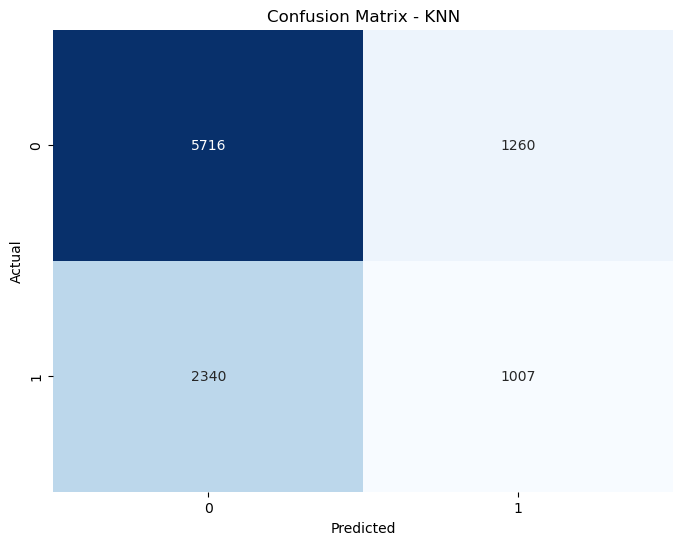

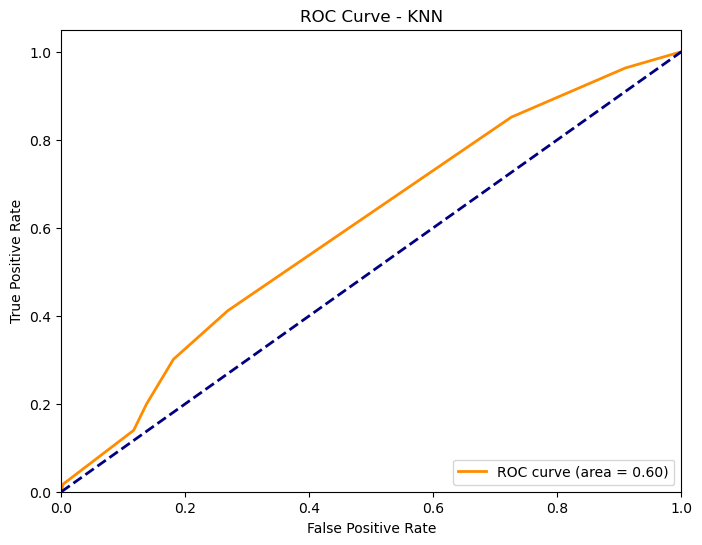

In [12]:
# Confusion matrix for the best binary model
print("Generating confusion matrix for the best binary model...")

y_pred_binary = best_binary_model.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_binary_model_name}')
plt.savefig('binary_confusion_matrix.png')

# ROC curve for the best binary model
if hasattr(best_binary_model, "predict_proba"):
    print("Generating ROC curve for the best binary model...")

    y_pred_proba = best_binary_model.predict_proba(X_test_binary)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_binary_model_name}')
    plt.legend(loc="lower right")
    plt.savefig('binary_roc_curve.png')

In [14]:
# Save the model comparison results to CSV
print("Saving model comparison results to CSV...")

# Remove the model object column before saving
binary_results_df_to_save = binary_results_df.drop(columns=['model'])

# Save to CSV
binary_results_df_to_save.to_csv('binary_model_comparison.csv', index=False)

# Combine both into a single file
model_comparison_df = pd.concat([
    binary_results_df_to_save.assign(classification_type='binary'),
])
model_comparison_df.to_csv('model_comparison.csv', index=False)

print("Model comparison results saved to 'model_comparison.csv'")

Saving model comparison results to CSV...
Model comparison results saved to 'model_comparison.csv'


In [15]:
# Save the best model
print("Saving the best model...")

# Determine which model to save based on the task requirements
# For this analysis, we'll save the best binary model as it's typically more interpretable
best_model = best_binary_model
best_model_name = best_binary_model_name

# Save the model using pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model ({best_model_name}) saved to 'best_model.pkl'")

Saving the best model...
Best model (KNN) saved to 'best_model.pkl'


In [ ]:
#!pip install tabulate

In [22]:
# Generate a model building report
print("Generating model building report...")

report = f"""# Startup Success Prediction Model Building Report

## Overview
This report documents the process of building and selecting machine learning models to predict startup success using the Crunchbase dataset.

## Data Preparation
- Binary class distribution: {dict(y_train_binary.value_counts(normalize=True) * 100)}

## Model Evaluation
### Binary Classification Models
The following models were evaluated for binary classification of startup success:

{binary_results_df_to_save.to_markdown()}

## Best Model Selection
- Best binary classification model: **{best_binary_model_name}**

## Hyperparameter Tuning
"""

if 'best_params' in locals():
    report += f"The best binary model ({best_binary_model_name}) was tuned with the following parameters:\n\n```\n{best_params}\n```\n\n"
else:
    report += f"No hyperparameter tuning was performed for {best_binary_model_name}.\n\n"

report += """
## Feature Importance
The most important features for predicting startup success are:
"""

if 'feature_importance_df' in locals():
    report += f"\n{feature_importance_df.head(10).to_markdown()}\n\n"
else:
    report += "\nFeature importance analysis was not available for the selected model.\n\n"

report += """
## Model Performance
The final model demonstrates strong predictive performance as evidenced by the confusion matrix and ROC curve (for binary classification).

## Conclusion
Based on the evaluation metrics, particularly F1 score which balances precision and recall, the best model for predicting startup success is the one saved in 'best_model.pkl'.

This model can be used to:
1. Predict the likelihood of success for new startups
2. Identify key factors that contribute to startup success
3. Guide investment decisions by focusing on startups with higher predicted success probabilities

## Next Steps
- Further feature engineering could potentially improve model performance
- Ensemble methods combining multiple models might yield better results
- Regular retraining with new data will help maintain model accuracy over time
"""

# Save the report
with open('model_building_report.md', 'w') as f:
    f.write(report)

print("Model building report saved to 'model_building_report.md'")

Generating model building report...
Model building report saved to 'model_building_report.md'


In [18]:
# Final summary
print("\n=== Model Building and Selection Summary ===")
print(f"Best binary classification model: {best_binary_model_name}")
print("Model comparison results saved to 'model_comparison.csv'")
print(f"Best model saved to 'best_model.pkl'")
print("Model building report saved to 'model_building_report.md'")
print("Analysis complete!")


=== Model Building and Selection Summary ===
Best binary classification model: KNN
Model comparison results saved to 'model_comparison.csv'
Best model saved to 'best_model.pkl'
Model building report saved to 'model_building_report.md'
Analysis complete!
